<a href="https://colab.research.google.com/github/XG11/ECE420FinalProject/blob/main/ECE420FinalProjectPythonPrototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude
from scipy.spatial.distance import euclidean
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2

In [3]:
from google.colab import files
from PIL import Image
import numpy as np

# Upload images
uploaded_images1 = files.upload()
uploaded_images2 = files.upload()

# Get file paths from the uploaded images
image_path1 = next(iter(uploaded_images1))
image_path2 = next(iter(uploaded_images2))

# Load the images as grayscale
image1 = Image.open(image_path1).convert('L')
image2 = Image.open(image_path2).convert('L')

# Convert images to numpy arrays
# Convert images to float32 type for gradient calculations
image1_np = np.array(image1, dtype=np.float32)
image2_np = np.array(image2, dtype=np.float32)


Saving Stop1.jpg to Stop1.jpg


Saving stop2.jpg to stop2.jpg


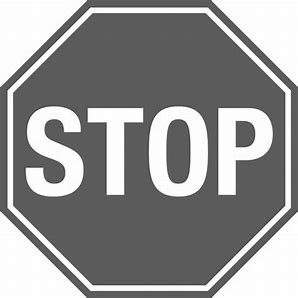

4


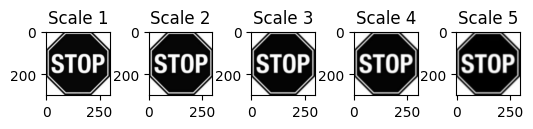

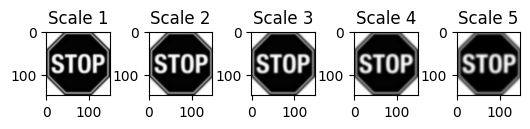

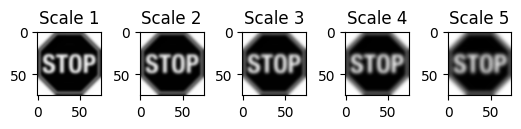

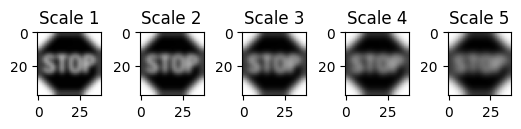

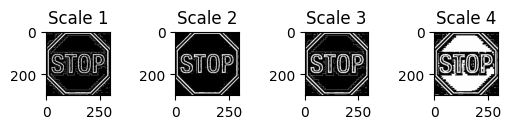

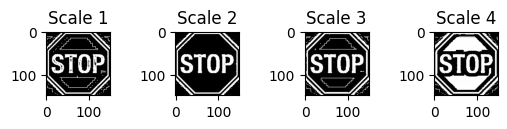

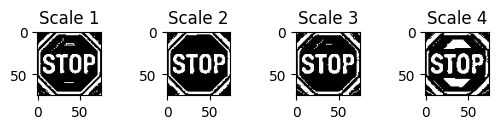

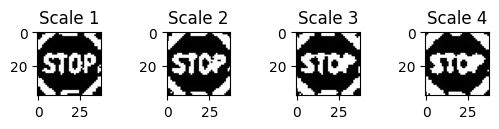

In [43]:
#applies gaussian kernel in spacial domain to image using sigma blur operator to generate blurred image in each scale
'''def BlurredImage(image, sigma):
  gaussian = np.zeros((image.shape[0], image.shape[1]))
  for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
      gaussian[i][j] = 1/(2 * np.pi * sigma * sigma) * np.exp(-1 * (np.square(i) + np.square(j))/(2 * np.square(sigma)))
  L = convolve2d(image, gaussian, mode='same')
  return L

#takes in image, sigma, number of scales, and number of octaves
#returns a list of lists with each list containing images with different scales and each list representing octave
def octaves(image, sigma, scale, octave):
  l_images = []
  num_octave = []
  im_copy = image.copy()
  for o in range(0, octave):
    if(o != 0):
      im_copy = cv2.resize(im_copy, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    r_image = im_copy.copy()
    for s in range(0, scale):
       r_image = BlurredImage(r_image, sigma)
       num_octave.append(r_image)
    l_images.append(num_octave)
    for s in range(0, scale):
      num_octave.pop()
  return l_images'''
def generate_scale_space(image, num_octaves=4, num_scales=5, sigma=1.2):
    octaves = []
    for octave in range(num_octaves):
        scales = []
        k = 2 ** (1 / num_scales)
        for scale in range(num_scales):
            sigma_scale = sigma * (k ** scale)
            blurred_image = gaussian_filter(image, sigma=sigma_scale)
            scales.append(blurred_image)
        octaves.append(scales)
        image = scales[-3][::2, ::2]
    return octaves


#returns difference of gaussian images within each octave, need to call previous octave function to input into this
def DOG(l_images):
  d_images = []
  #num_octave = []
  for i in range(0, len(l_images)):
    num_octave = []
    for j in range(0, len(l_images[i]) - 1):
      difference = l_images[i][j+1] - l_images[i][j]
      num_octave.append(difference)
    d_images.append(num_octave)
    #num_octave.clear()
  return d_images


# Load the "statue" image from OpenCV's samples dataset
from google.colab.patches import cv2_imshow
image_1 = cv2.imread('Stop1.jpg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(image_1)
#l_images_1 = octaves(image_1, 1, 5, 4) #sigma = 1, scale = 5, octave = 4
l_images_1 = generate_scale_space(image_1)
#print(l_images_1)
#l_images_2 = octaves(image_2, 1, 5, 4) #sigma = 1, scale = 5, octave = 4
d_images_1 = DOG(l_images_1) #get difference of gaussians
print(len(d_images_1))
#print(d_images_1)
#d_images_2 = DOG(l_images_2) #get difference of gaussians

def plot_images(images, title):
    for i, img in enumerate(images):
        plt.subplot(5, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Scale {i+1}")
        #plt.axis('off')
    #plt.suptitle(title, fontsize=16)
    plt.show()

for i, octave in enumerate(l_images_1):
    plot_images(octave, f"Scale Space (Octave {i+1})")

for i, octave in enumerate(d_images_1):
    plot_images(octave, f"DOG (Octave {i+1})")

In [45]:
#this function returns all keypoints taking in the difference of gaussians
def keypoints(d_images, threshold = 0.3):
  keypoints = []
  scale_factor = 2
  for o, octave in enumerate(d_images):
    for s in range(len(octave)):
      scale = octave[s]
      current = scale
      #print(s)
      #print(len(octave))
      prev = octave[s - 1] if s > 0 else None  # Previous scale (handle the first scale)
      next = octave[s + 1] if s < len(octave) - 1 else None  # Next scale (handle the last scale)
      #print(prev)
      #print(next)
      for i in range(1, current.shape[0] - 1):
        for j in range(1, current.shape[1] - 1):
          current_pixel = current[i][j]
          if abs(current_pixel) < threshold:
            continue
          if prev is None:
            neighborhood = [current[i-1:i+2, j-1:j+2], next[i-1:i+2, j-1:j+2]]
          elif next is None:
            neighborhood = [prev[i-1:i+2, j-1:j+2], current[i-1:i+2, j-1:j+2]]
          else:
            neighborhood = [prev[i-1:i+2, j-1:j+2], current[i-1:i+2, j-1:j+2], next[i-1:i+2, j-1:j+2]]
          max_val = np.max(neighborhood)
          min_val = np.min(neighborhood)
          if current_pixel == max_val or current_pixel == min_val:
            original_i = i * (scale_factor ** (o + 1))
            original_j = j * (scale_factor ** (o + 1))
            keypoints.append([o, s, original_i, original_j])

  return keypoints

keypoint_result_1 = keypoints(d_images_1, threshold = 0.3) #get keypoint results
#keypoint_result_2 = keypoints(d_images_2, threshold = 0.3) #get keypoint results

In [ ]:
#do gradient calculations for neighborhood around image based on scale(sigma level of blurring in particular image
#does calculation of gradients for one keypoint, must be called with each keypoint
def M_theta_calculation(image, keypoint):
    x, y = keypoint[2], keypoint[3]
    scale = keypoint[1]
    if(scale > 2):
      radius = 16
    else:
      radius = 8
    gradient_magnitudes = []
    gradient_orientations = []

    # Compute gradient magnitudes and orientations around the keypoint
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if (0 < x + i < image.shape[0] - 1) and (0 < y + j < image.shape[1] - 1):
                dx = image[x + i, y + j + 1] - image[x + i, y + j - 1]
                dy = image[x + i + 1, y + j] - image[x + i - 1, y + j]
                magnitude = np.sqrt(dx**2 + dy**2)
                orientation = np.degrees(np.arctan2(dy, dx)) % 360
                gradient_magnitudes.append(magnitude)
                gradient_orientations.append(orientation)
    return gradient_magnitudes, gradient_orientations

#creates histogram based on bin size and returns it and the dominant orientation
def histogram(gradient_magnitudes, gradient_orientations, bin_size):
   orientation_histogram = np.zeros(bin_size)
   for magnitude, orientation in zip(gradient_magnitudes, gradient_orientations):
     if(orientation == 360):
       bin_index = 0
     else:
       bin_index = int(orientation // (360 // bin_size))
     orientation_histogram[bin_index] += magnitude
   dominant_orientation = np.argmax(orientation_histogram) * (360 // bin_size)
   return(orientation_histogram, dominant_orientation)

dominant_orientations_1 = []
dominant_orientations_2 = []
for k in range(0, len(keypoint_result_1)):
  gradient_magnitudes_1, gradient_orientations_1 = M_theta_calculation(image_1, keypoint_result_1[k])
  gradient_magnitudes_2, gradient_orientations_2 = M_theta_calculation(image_2, keypoint_result_2[k])

  dominant_orientation_1 = histogram(gradient_magnitudes_1, gradient_orientations_1, 36)[1]
  dominant_orientation_2 = histogram(gradient_magnitudes_2, gradient_orientations_2, 36)[1]

  dominant_orientations_1.append(dominant_orientation_1)
  dominant_orientations_2.append(dominant_orientation_2)

IndentationError: unexpected indent (<ipython-input-1-267be712619f>, line 6)

In [ ]:
def compute_gradient(image, x, y):
    """
    Compute gradient magnitude and orientation at pixel (x, y) using central difference.
    """
    dx = image[x, y + 1] - image[x, y - 1]  # Central difference in the x direction
    dy = image[x + 1, y] - image[x - 1, y]  # Central difference in the y direction

    magnitude = np.sqrt(dx**2 + dy**2)  # Gradient magnitude
    orientation = np.degrees(np.arctan2(dy, dx)) % 360  # Gradient orientation (0 to 360 degrees)

    return magnitude, orientation

def compute_keypoint_descriptor(image, keypoint, dominant_orientation):
    """
    Compute the descriptor for the keypoint in the image.
    """
    # Extract a scaled window around the keypoint (taking scale into account)
    #scaled_window = extract_scaled_patch(image, keypoint, window_size)

    # Compute gradients and orientations
    #gx, gy = compute_gradients(scaled_window)
    #magnitude, orientation = compute_magnitude_orientation(gx, gy)

    # Create histograms for each 4x4 sub-block
    descriptor = []
    gradient_magnitudes = []
    gradient_orientations = []
    x_start = keypoint[2] - 8
    y_start = keypoint[3] - 8
    for o_x in range(x_start, x_start + 16, 4):
      for o_y in range(y_start, y_start + 16, 4):
        for s_x in range(o_x, o_x + 4):
          for s_y in range(o_y, o_y + 4):
               if s_x > 0 and s_y > 0 and s_x < image.shape[0] - 1 and s_y < image.shape[1] - 1:
                    # Compute the gradient for each pixel (x, y)
                    magnitude, orientation = compute_gradient(image, s_x, s_y)
                    # Append the magnitude and orientation for later use

                    #subtract dominant orientation for rotation independance
                    orientation = (orientation - dominant_orientation)%360
                    gradient_magnitudes.append(magnitude)
                    gradient_orientations.append(orientation)
        desc_values = histogram(gradient_magnitudes, gradient_orientations, 8)
        for i in range(0, len(desc_values[0])):
          if(desc_values[0][i] > 0.2):
              descriptor.append(0.2)
          else:
              descriptor.append(desc_values[0][i])
              gradient_magnitudes.clear()
              gradient_orientations.clear()
  # Calculate the L2 norm (Euclidean norm) of the descriptor vector
    norm = np.linalg.norm(descriptor)
  # If the norm is not zero, normalize the descriptor (avoid division by zero)
    if norm != 0:
      descriptor_vector /= norm
    return descriptor

descriptors_1 = []
descriptors_2 = []
for k in range(0, len(keypoint_result_1)):
  descriptor_1 = compute_keypoint_descriptor(image_1, keypoint_result_1[k], dominant_orientations_1[k])
  descriptors_1.append(descriptor_1)
for k in range(0, len(keypoint_result_2)):
  descriptor_2 = compute_keypoint_descriptor(image_2, keypoint_result_2[k], dominant_orientations_2[k])
  descriptors_2.append(descriptor_2)

  #do keypoint matching and drawing down here
  mg_matches = cv2.drawMatches(
    img1, keypoint_result_1, img2, keypoint_result_2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)